# Bitcoin Sentiment vs Trader Performance Analysis

---
## Importing Necessary Files

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

---
## Load and preprocess data

In [ ]:
def load_and_preprocess_data(trader_file_path='historical_data.csv', sentiment_file_path='fear_greed_index.csv'):

    trader_data = pd.read_csv(trader_file_path)
    sentiment_data = pd.read_csv(sentiment_file_path)

    print(f"Trader data columns: {list(trader_data.columns)}")
    print(f"Sentiment data columns: {list(sentiment_data.columns)}")

    trader_data = preprocess_trader_data(trader_data)
    sentiment_data = preprocess_sentiment_data(sentiment_data)

    print(f"\nAfter preprocessing:")
    print(f"Trader data shape: {trader_data.shape}")
    print(f"Sentiment data shape: {sentiment_data.shape}")

    # Date overlap
    trader_dates = set(trader_data['date'])
    sentiment_dates = set(sentiment_data['date'])
    overlap = trader_dates.intersection(sentiment_dates)
    print(f"\nDate overlap: {len(overlap)} days")

    return trader_data, sentiment_data

def preprocess_trader_data(trader_data):

    df = trader_data.copy()

    timestamp_cols = ['Timestamp IST', 'timestamp', 'time', 'Time', 'Timestamp']
    timestamp_col = None
    for col in timestamp_cols:
        if col in df.columns:
            timestamp_col = col
            break

    if timestamp_col is None:
        raise ValueError(f"No timestamp column found. Available columns: {list(df.columns)}")

    df['datetime'] = pd.to_datetime(df[timestamp_col], errors='coerce')
    df['date'] = df['datetime'].dt.date

    account_cols = ['Account', 'account', 'user', 'trader_id']
    account_col = None
    for col in account_cols:
        if col in df.columns:
            account_col = col
            break

    if account_col:
        df['Account'] = df[account_col]
    else:
        df['Account'] = 'trader_' + (df.index // 100).astype(str)

    pnl_cols = ['Closed PnL', 'closedPnL', 'pnl', 'PnL', 'profit_loss']
    pnl_col = None
    for col in pnl_cols:
        if col in df.columns:
            pnl_col = col
            break

    if pnl_col:
        df['Closed PnL'] = pd.to_numeric(df[pnl_col], errors='coerce')
    else:
        df['Closed PnL'] = 0

    size_usd_cols = ['Size USD', 'size_usd', 'volume_usd', 'Size Tokens', 'size']
    size_col = None
    for col in size_usd_cols:
        if col in df.columns:
            size_col = col
            break

    if size_col:
        df['Size USD'] = pd.to_numeric(df[size_col], errors='coerce')
    else:
        df['Size USD'] = 100

    price_cols = ['Execution Price', 'execution_price', 'price', 'Price']
    price_col = None
    for col in price_cols:
        if col in df.columns:
            price_col = col
            break

    if price_col:
        df['Execution Price'] = pd.to_numeric(df[price_col], errors='coerce')
    else:
        df['Execution Price'] = np.nan

    side_cols = ['Side', 'side', 'Direction', 'direction']
    side_col = None
    for col in side_cols:
        if col in df.columns:
            side_col = col
            break

    if side_col:
        df['is_buy'] = df[side_col].astype(str).str.upper().isin(['BUY', 'LONG', '1', 'TRUE'])
    else:
        df['is_buy'] = np.random.choice([True, False], size=len(df))  # Random for analysis

    essential_cols = ['datetime', 'date', 'Account']
    df = df.dropna(subset=essential_cols)

    df['Closed PnL'] = df['Closed PnL'].fillna(0)
    df['Size USD'] = df['Size USD'].fillna(100)

    return df

def preprocess_sentiment_data(sentiment_data):
    df = sentiment_data.copy()

    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date
    elif 'timestamp' in df.columns:
        timestamps = pd.to_numeric(df['timestamp'], errors='coerce')
        if timestamps.max() > 4000000000:
            df['datetime'] = pd.to_datetime(timestamps, unit='ms', errors='coerce')
        else:
            df['datetime'] = pd.to_datetime(timestamps, unit='s', errors='coerce')
        df['date'] = df['datetime'].dt.date
    else:
        raise ValueError("Sentiment data must contain 'date' or 'timestamp' column.")

    if 'value' in df.columns:
        df['sentiment_value'] = pd.to_numeric(df['value'], errors='coerce')
    else:
        print("Warning: No 'value' column found in sentiment data")
        df['sentiment_value'] = 50

    if 'classification' in df.columns:
        df['sentiment_category'] = df['classification'].astype(str).str.title()

        category_mapping = {
            'Extreme Fear': 'Extreme Fear',
            'Fear': 'Fear',
            'Neutral': 'Neutral',
            'Greed': 'Greed',
            'Extreme Greed': 'Extreme Greed'
        }

        df['sentiment_category'] = df['sentiment_category'].replace({
            'Extremefear': 'Extreme Fear',
            'Extremegreed': 'Extreme Greed'
        })

    else:
        print("Creating sentiment categories from values...")
        df['sentiment_category'] = pd.cut(df['sentiment_value'],
                                        bins=[0, 25, 45, 55, 75, 100],
                                        labels=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])

    sentiment_mapping = {
        'Extreme Fear': 1,
        'Fear': 2,
        'Neutral': 3,
        'Greed': 4,
        'Extreme Greed': 5
    }
    df['sentiment_score'] = df['sentiment_category'].map(sentiment_mapping)

    df = df.dropna(subset=['date'])

    if df['sentiment_value'].isna().any():
        df['sentiment_value'] = df['sentiment_value'].fillna(df['sentiment_value'].median())

    return df

trader_data, sentiment_data = load_and_preprocess_data()

Trader data columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Sentiment data columns: ['timestamp', 'value', 'classification', 'date']

After preprocessing:
Trader data shape: (79225, 19)
Sentiment data shape: (2644, 7)

Date overlap: 158 days


---
## Merge datasets

In [ ]:
def merge_datasets(trader_data, sentiment_data):

    print("Merging datasets...")

    # Aggregate trader data by date with more comprehensive metrics
    trader_daily = trader_data.groupby('date').agg({
        'Account': 'nunique',
        'Closed PnL': ['sum', 'mean', 'std', 'count', 'median'],
        'Size USD': ['sum', 'mean', 'median'],
        'is_buy': ['sum', 'mean'],
        'Execution Price': ['mean', 'std', 'min', 'max']
    }).reset_index()

    # Flatten column names
    trader_daily.columns = [
        'date', 'unique_traders', 'total_pnl', 'avg_pnl', 'pnl_std', 'trade_count', 'median_pnl',
        'total_volume', 'avg_trade_size', 'median_trade_size', 'buy_trades', 'buy_ratio',
        'avg_price', 'price_volatility', 'min_price', 'max_price'
    ]

    trader_daily['profitable_ratio'] = (trader_daily['total_pnl'] > 0).astype(float)
    trader_daily['avg_pnl_per_trader'] = trader_daily['total_pnl'] / trader_daily['unique_traders']
    trader_daily['price_range'] = trader_daily['max_price'] - trader_daily['min_price']
    trader_daily['volume_per_trader'] = trader_daily['total_volume'] / trader_daily['unique_traders']
    trader_daily['pnl_volatility'] = trader_daily['pnl_std'] / (abs(trader_daily['avg_pnl']) + 1)

    trader_daily = trader_daily.sort_values('date')
    trader_daily['rolling_pnl_7d'] = trader_daily['total_pnl'].rolling(window=7, min_periods=1).mean()
    trader_daily['rolling_volume_7d'] = trader_daily['total_volume'].rolling(window=7, min_periods=1).mean()

    merged_data = pd.merge(trader_daily, sentiment_data, on='date', how='inner')

    print(f"Merged data shape: {merged_data.shape}")
    print(f"Date range: {merged_data['date'].min()} to {merged_data['date'].max()}")

    return merged_data

merged_data = merge_datasets(trader_data, sentiment_data)

Merging datasets...
Merged data shape: (158, 29)
Date range: 2023-01-05 to 2025-05-02


---
## Analysis

In [ ]:
def analyze_sentiment_performance_correlation(merged_data):

    print("\n" + "="*60)
    print("SENTIMENT vs PERFORMANCE CORRELATION ANALYSIS")
    print("="*60)

    correlations = {}
    performance_metrics = [
        'total_pnl', 'avg_pnl', 'buy_ratio', 'trade_count',
        'avg_trade_size', 'profitable_ratio', 'unique_traders', 'pnl_volatility'
    ]

    print(f"{'Metric':<20} {'Pearson':<10} {'P-value':<10} {'Spearman':<10} {'Interpretation'}")
    print("-" * 80)

    for metric in performance_metrics:
        if metric in merged_data.columns and 'sentiment_value' in merged_data.columns:
            valid_data = merged_data[[metric, 'sentiment_value']].dropna()
            if len(valid_data) > 3:
                # Pearson correlation
                pearson_corr, pearson_p = pearsonr(valid_data[metric], valid_data['sentiment_value'])
                # Spearman correlation (rank-based, more robust)
                spearman_corr, spearman_p = spearmanr(valid_data[metric], valid_data['sentiment_value'])

                strength = "Strong" if abs(pearson_corr) > 0.5 else "Moderate" if abs(pearson_corr) > 0.3 else "Weak"
                direction = "Positive" if pearson_corr > 0 else "Negative"
                significance = "Significant" if pearson_p < 0.05 else "Not Significant"

                correlations[metric] = {
                    'pearson_corr': pearson_corr,
                    'pearson_p': pearson_p,
                    'spearman_corr': spearman_corr,
                    'spearman_p': spearman_p,
                    'interpretation': f"{strength} {direction} ({significance})"
                }

                print(f"{metric:<20} {pearson_corr:>7.3f} {pearson_p:>9.3f} {spearman_corr:>9.3f} {strength} {direction}")
            else:
                print(f"{metric:<20} {'Insufficient data'}")

    return correlations

# Run correlation analysis
correlations = analyze_sentiment_performance_correlation(merged_data)


SENTIMENT vs PERFORMANCE CORRELATION ANALYSIS
Metric               Pearson    P-value    Spearman   Interpretation
--------------------------------------------------------------------------------
total_pnl             -0.057     0.475    -0.021 Weak Negative
avg_pnl               -0.008     0.921     0.049 Weak Negative
buy_ratio              0.026     0.745     0.054 Weak Positive
trade_count           -0.188     0.018    -0.134 Weak Negative
avg_trade_size         0.171     0.032     0.170 Weak Positive
profitable_ratio       0.055     0.492     0.050 Weak Positive
unique_traders        -0.163     0.041    -0.085 Weak Negative
pnl_volatility        -0.113     0.166    -0.045 Weak Negative


In [ ]:
def sentiment_based_performance_analysis(merged_data):

    print("\n" + "="*60)
    print("PERFORMANCE BY SENTIMENT CATEGORY")
    print("="*60)

    # Group by sentiment category
    sentiment_groups = merged_data.groupby('sentiment_category')

    # Comprehensive statistics
    sentiment_analysis = sentiment_groups.agg({
        'total_pnl': ['mean', 'median', 'std', 'count', 'sum'],
        'avg_pnl': ['mean', 'median'],
        'buy_ratio': ['mean', 'std'],
        'trade_count': ['mean', 'median'],
        'unique_traders': ['mean', 'median'],
        'avg_trade_size': ['mean', 'median'],
        'profitable_ratio': 'mean'
    }).round(3)

    # Confidence intervals
    for sentiment in sentiment_groups.groups.keys():
        group_data = sentiment_groups.get_group(sentiment)
        if len(group_data) > 1:
            ci = stats.t.interval(0.95, len(group_data)-1,
                                loc=group_data['total_pnl'].mean(),
                                scale=stats.sem(group_data['total_pnl']))
            print(f"\n{sentiment}:")
            print(f"  Mean PnL: ${group_data['total_pnl'].mean():.2f}")
            print(f"  95% CI: [${ci[0]:.2f}, ${ci[1]:.2f}]")
            print(f"  Sample size: {len(group_data)} days")
            print(f"  Win rate: {group_data['profitable_ratio'].mean():.1%}")

    return sentiment_analysis

# Run sentiment-based performance analysis
sentiment_analysis = sentiment_based_performance_analysis(merged_data)


PERFORMANCE BY SENTIMENT CATEGORY

Extreme Fear:
  Mean PnL: $733.32
  95% CI: [$-2203.35, $3669.99]
  Sample size: 6 days
  Win rate: 50.0%

Extreme Greed:
  Mean PnL: $26904.50
  95% CI: [$-7709.33, $61518.34]
  Sample size: 43 days
  Win rate: 72.1%

Fear:
  Mean PnL: $48087.18
  95% CI: [$3754.14, $92420.21]
  Sample size: 37 days
  Win rate: 70.3%

Greed:
  Mean PnL: $10886.30
  95% CI: [$309.89, $21462.70]
  Sample size: 56 days
  Win rate: 71.4%

Neutral:
  Mean PnL: $4666.05
  95% CI: [$-1092.09, $10424.19]
  Sample size: 16 days
  Win rate: 56.2%


In [ ]:
def identify_profitable_patterns(merged_data):
    print("\n" + "="*60)
    print("PROFITABLE TRADING PATTERNS")
    print("="*60)

    profitable_days = merged_data[merged_data['total_pnl'] > 0]
    loss_days = merged_data[merged_data['total_pnl'] <= 0]

    print(f"Profitable days: {len(profitable_days)} ({len(profitable_days)/len(merged_data):.1%})")
    print(f"Loss days: {len(loss_days)} ({len(loss_days)/len(merged_data):.1%})")

    from scipy.stats import chi2_contingency

    contingency_table = pd.crosstab(
        merged_data['total_pnl'] > 0,
        merged_data['sentiment_category']
    )

    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"\n Chi-square test for sentiment-profitability independence:")
    print(f"   Chi-square statistic: {chi2:.3f}")
    print(f"   P-value: {p_value:.3f}")
    print(f"   Result: {'Sentiment affects profitability' if p_value < 0.05 else 'No significant relationship'}")

    print(f"\n Sentiment distribution on profitable days:")
    profitable_sentiment = profitable_days['sentiment_category'].value_counts(normalize=True)
    for sentiment, ratio in profitable_sentiment.items():
        print(f"   {sentiment}: {ratio:.1%}")

    print(f"\n Sentiment distribution on loss days:")
    loss_sentiment = loss_days['sentiment_category'].value_counts(normalize=True)
    for sentiment, ratio in loss_sentiment.items():
        print(f"   {sentiment}: {ratio:.1%}")

    # Trading behavior differences
    print(f"\n Trading behavior comparison:")
    print(f"   Profitable days - Avg buy ratio: {profitable_days['buy_ratio'].mean():.1%}")
    print(f"   Loss days - Avg buy ratio: {loss_days['buy_ratio'].mean():.1%}")
    print(f"   Profitable days - Avg trade size: ${profitable_days['avg_trade_size'].mean():.0f}")
    print(f"   Loss days - Avg trade size: ${loss_days['avg_trade_size'].mean():.0f}")

    return profitable_days, loss_days, contingency_table

# Identify profitable patterns
profitable_days, loss_days, contingency_table = identify_profitable_patterns(merged_data)


PROFITABLE TRADING PATTERNS
Profitable days: 109 (69.0%)
Loss days: 49 (31.0%)

 Chi-square test for sentiment-profitability independence:
   Chi-square statistic: 2.603
   P-value: 0.626
   Result: No significant relationship

 Sentiment distribution on profitable days:
   Greed: 36.7%
   Extreme Greed: 28.4%
   Fear: 23.9%
   Neutral: 8.3%
   Extreme Fear: 2.8%

 Sentiment distribution on loss days:
   Greed: 32.7%
   Extreme Greed: 24.5%
   Fear: 22.4%
   Neutral: 14.3%
   Extreme Fear: 6.1%

 Trading behavior comparison:
   Profitable days - Avg buy ratio: 48.2%
   Loss days - Avg buy ratio: 56.0%
   Profitable days - Avg trade size: $5811
   Loss days - Avg trade size: $8472


In [ ]:
def advanced_pattern_analysis(merged_data):
    print("\n" + "="*60)
    print("ADVANCED PATTERN ANALYSIS")
    print("="*60)

    df = merged_data.sort_values('date').copy()

    # Rolling metrics with multiple windows
    for window in [3, 7, 14]:
        df[f'rolling_pnl_{window}d'] = df['total_pnl'].rolling(window=window, min_periods=1).mean()
        df[f'rolling_sentiment_{window}d'] = df['sentiment_value'].rolling(window=window, min_periods=1).mean()

    # Trend detection
    df['pnl_trend'] = np.where(df['rolling_pnl_7d'] > df['rolling_pnl_7d'].shift(1), 'Up', 'Down')
    df['sentiment_trend'] = np.where(df['rolling_sentiment_7d'] > df['rolling_sentiment_7d'].shift(1), 'Up', 'Down')

    # Volatility regimes
    df['pnl_volatility_regime'] = pd.qcut(df['pnl_volatility'], q=3, labels=['Low', 'Medium', 'High'])
    df['sentiment_volatility'] = df['sentiment_value'].rolling(window=7).std()
    df['sentiment_vol_regime'] = pd.qcut(df['sentiment_volatility'], q=3, labels=['Stable', 'Moderate', 'Volatile'])

    # Regime change detection
    df['sentiment_change'] = df['sentiment_value'].diff().abs()
    df['large_sentiment_change'] = df['sentiment_change'] > df['sentiment_change'].quantile(0.75)

    # Analysis
    print("PnL Trend vs Sentiment Trend:")
    trend_crosstab = pd.crosstab(df['pnl_trend'], df['sentiment_trend'], normalize='columns')
    print(trend_crosstab.round(3))

    print(f"\nPerformance during large sentiment changes:")
    regime_stats = df.groupby('large_sentiment_change')['total_pnl'].agg(['mean', 'std', 'count'])
    print(regime_stats.round(2))

    # Volatility analysis
    print(f"\nPerformance by volatility regime:")
    vol_analysis = df.groupby('pnl_volatility_regime')['total_pnl'].agg(['mean', 'count'])
    print(vol_analysis.round(2))

    return df

# Run advanced pattern analysis
advanced_df = advanced_pattern_analysis(merged_data)
# Store the enhanced dataframe for later use
merged_data_advanced = advanced_df


ADVANCED PATTERN ANALYSIS
PnL Trend vs Sentiment Trend:
sentiment_trend   Down     Up
pnl_trend                    
Down             0.434  0.512
Up               0.566  0.488

Performance during large sentiment changes:
                            mean        std  count
large_sentiment_change                            
False                   17032.77   78167.01    120
True                    41602.00  122070.41     38

Performance by volatility regime:
                           mean  count
pnl_volatility_regime                 
Low                     1574.21     51
Medium                  1241.63     51
High                   68258.84     51


In [ ]:

def backtest_sentiment_strategy(merged_data):
    print("\n" + "="*60)
    print("SENTIMENT-BASED STRATEGY BACKTEST")
    print("="*60)

    df = merged_data.sort_values('date').copy()

    # Multiple strategy variants
    strategies = {
        'contrarian': np.where(df['sentiment_category'] == 'Extreme Fear', 1,
                             np.where(df['sentiment_category'] == 'Extreme Greed', -1, 0)),
        'momentum': np.where(df['sentiment_category'] == 'Greed', 1,
                           np.where(df['sentiment_category'] == 'Fear', -1, 0)),
        'value_based': np.where(df['sentiment_value'] < 25, 1,
                              np.where(df['sentiment_value'] > 75, -1, 0))
    }

    results = {}

    for strategy_name, signals in strategies.items():
        df[f'{strategy_name}_signal'] = signals

        # Calculate returns (using PnL as proxy)
        df[f'{strategy_name}_return'] = df['total_pnl'] * df[f'{strategy_name}_signal'] / 10000  # Scale down
        df[f'{strategy_name}_cumulative'] = (1 + df[f'{strategy_name}_return']).cumprod() - 1

        # Performance metrics
        returns = df[f'{strategy_name}_return'].dropna()
        if len(returns) > 0 and returns.std() > 0:
            sharpe = returns.mean() / returns.std() * np.sqrt(252)
            win_rate = (returns > 0).mean()
            max_drawdown = (df[f'{strategy_name}_cumulative'] - df[f'{strategy_name}_cumulative'].cummax()).min()
            final_return = df[f'{strategy_name}_cumulative'].iloc[-1]

            results[strategy_name] = {
                'final_return': final_return,
                'sharpe_ratio': sharpe,
                'win_rate': win_rate,
                'max_drawdown': max_drawdown,
                'total_trades': (signals != 0).sum()
            }

            print(f"\n{strategy_name.upper()} STRATEGY:")
            print(f"   Final Return: {final_return:.2%}")
            print(f"   Sharpe Ratio: {sharpe:.2f}")
            print(f"   Win Rate: {win_rate:.1%}")
            print(f"   Max Drawdown: {max_drawdown:.2%}")
            print(f"   Total Trades: {(signals != 0).sum()}")

    return df, results

# Run strategy backtest
backtest_df, strategy_results = backtest_sentiment_strategy(merged_data)


SENTIMENT-BASED STRATEGY BACKTEST

CONTRARIAN STRATEGY:
   Final Return: 58012.52%
   Sharpe Ratio: -1.95
   Win Rate: 5.7%
   Max Drawdown: -18010.39%
   Total Trades: 49

MOMENTUM STRATEGY:
   Final Return: -101433586258328.44%
   Sharpe Ratio: -1.64
   Win Rate: 27.8%
   Max Drawdown: -101682400948589.75%
   Total Trades: 93

VALUE_BASED STRATEGY:
   Final Return: 77161.06%
   Sharpe Ratio: -1.94
   Win Rate: 4.4%
   Max Drawdown: -23944.95%
   Total Trades: 41


In [ ]:
# Generate Trading Insights (Complete)
def generate_trading_insights(merged_data):
    """
    Generate comprehensive trading insights
    """
    print("\n" + "="*60)
    print("TRADING INSIGHTS & RECOMMENDATIONS")
    print("="*60)

    insights = []

    # 1. Best performing sentiment categories
    sentiment_performance = merged_data.groupby('sentiment_category')['avg_pnl'].mean().sort_values(ascending=False)
    best_sentiment = sentiment_performance.index[0]
    worst_sentiment = sentiment_performance.index[-1]

    insights.append(f"OPTIMAL SENTIMENT CONDITIONS:")
    insights.append(f"   Best: {best_sentiment} (Avg PnL: ${sentiment_performance.iloc[0]:.2f})")
    insights.append(f"   Worst: {worst_sentiment} (Avg PnL: ${sentiment_performance.iloc[-1]:.2f})")

    # 2. Volume-PnL relationship
    volume_correlation = merged_data[['total_volume', 'total_pnl']].corr().iloc[0,1]
    insights.append(f"\nVOLUME INSIGHTS:")
    insights.append(f"   Volume-PnL correlation: {volume_correlation:.3f}")

    high_vol = merged_data[merged_data['total_volume'] > merged_data['total_volume'].median()]
    low_vol = merged_data[merged_data['total_volume'] <= merged_data['total_volume'].median()]
    insights.append(f"   High volume days avg PnL: ${high_vol['avg_pnl'].mean():.2f}")
    insights.append(f"   Low volume days avg PnL: ${low_vol['avg_pnl'].mean():.2f}")

    # 3. Optimal trading behavior
    profitable_data = merged_data[merged_data['total_pnl'] > 0]
    if len(profitable_data) > 0:
        optimal_buy_ratio = profitable_data['buy_ratio'].mean()
        insights.append(f"\nBEHAVIORAL INSIGHTS:")
        insights.append(f"   Optimal buy ratio: {optimal_buy_ratio:.1%}")
        insights.append(f"   Profitable days trade count: {profitable_data['trade_count'].mean():.0f}")

    # 4. Risk management insights
    high_vol_sentiment = merged_data.groupby('sentiment_category')['pnl_volatility'].mean().sort_values(ascending=False)
    insights.append(f"\nRISK MANAGEMENT:")
    insights.append(f"   Highest risk sentiment: {high_vol_sentiment.index[0]}")
    insights.append(f"   Lowest risk sentiment: {high_vol_sentiment.index[-1]}")

    # 5. Market regime insights
    regime_performance = merged_data.groupby('sentiment_category').agg({
        'profitable_ratio': 'mean',
        'avg_pnl': 'mean',
        'trade_count': 'mean'
    }).round(3)

    best_regime = regime_performance['profitable_ratio'].idxmax()
    insights.append(f"\nBEST TRADING REGIME:")
    insights.append(f"   {best_regime} - Win rate: {regime_performance.loc[best_regime, 'profitable_ratio']:.1%}")

    for insight in insights:
        print(insight)

    return insights, sentiment_performance, regime_performance

# Execute trading insights
insights, sentiment_perf, regime_perf = generate_trading_insights(merged_data)


TRADING INSIGHTS & RECOMMENDATIONS
OPTIMAL SENTIMENT CONDITIONS:
   Best: Fear (Avg PnL: $56.31)
   Worst: Extreme Fear (Avg PnL: $8.95)

VOLUME INSIGHTS:
   Volume-PnL correlation: 0.598
   High volume days avg PnL: $57.21
   Low volume days avg PnL: $21.73

BEHAVIORAL INSIGHTS:
   Optimal buy ratio: 48.2%
   Profitable days trade count: 270

RISK MANAGEMENT:
   Highest risk sentiment: Extreme Fear
   Lowest risk sentiment: Extreme Greed

BEST TRADING REGIME:
   Extreme Greed - Win rate: 72.1%


---
## Plots

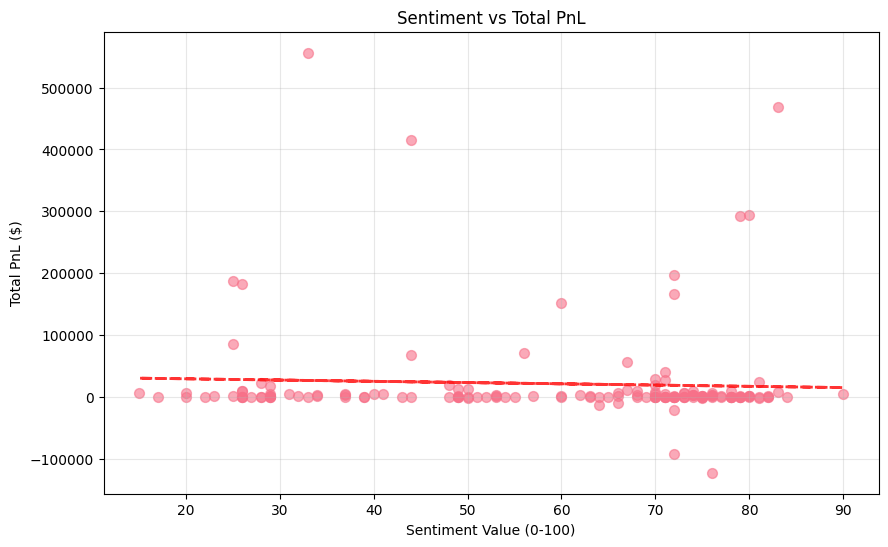

In [ ]:
def plot_sentiment_vs_pnl(merged_data):
    valid_data = merged_data[['sentiment_value', 'total_pnl']].dropna()
    plt.figure(figsize=(10, 6))
    plt.scatter(valid_data['sentiment_value'], valid_data['total_pnl'], alpha=0.6, s=50)
    z = np.polyfit(valid_data['sentiment_value'], valid_data['total_pnl'], 1)
    p = np.poly1d(z)
    plt.plot(valid_data['sentiment_value'], p(valid_data['sentiment_value']), "r--", alpha=0.8, linewidth=2)
    plt.xlabel('Sentiment Value (0-100)')
    plt.ylabel('Total PnL ($)')
    plt.title('Sentiment vs Total PnL')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_sentiment_vs_pnl(merged_data)


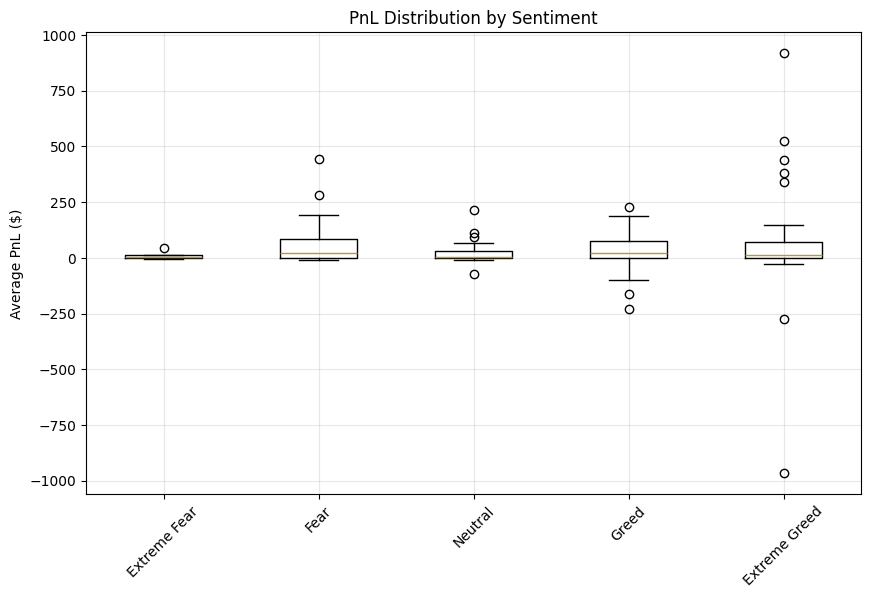

In [ ]:
def plot_pnl_by_sentiment_boxplot(merged_data):
    sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
    plot_data = []
    labels = []
    for sentiment in sentiment_order:
        if sentiment in merged_data['sentiment_category'].values:
            data = merged_data[merged_data['sentiment_category'] == sentiment]['avg_pnl'].dropna()
            if len(data) > 0:
                plot_data.append(data)
                labels.append(sentiment)
    if plot_data:
        plt.figure(figsize=(10, 6))
        plt.boxplot(plot_data, labels=labels)
        plt.ylabel('Average PnL ($)')
        plt.title('PnL Distribution by Sentiment')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.show()

plot_pnl_by_sentiment_boxplot(merged_data)

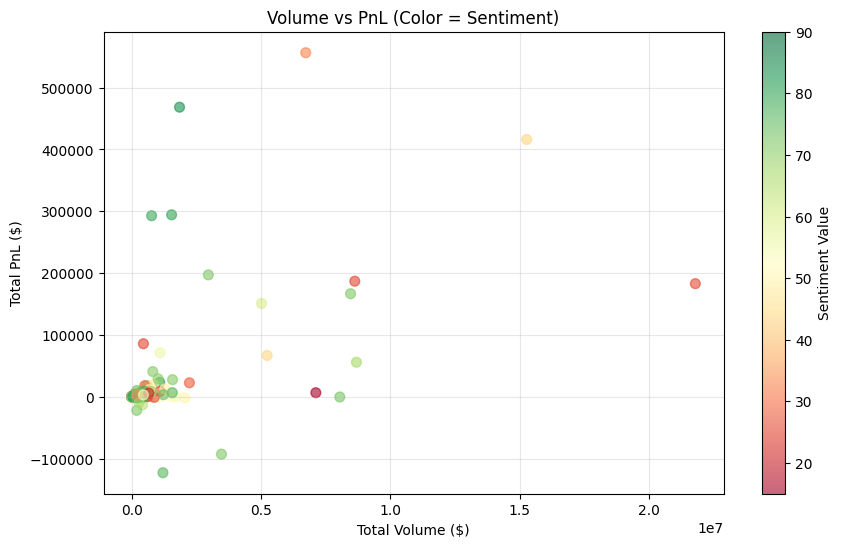

In [ ]:
def plot_volume_vs_pnl_colored(merged_data):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(merged_data['total_volume'], merged_data['total_pnl'],
                          c=merged_data['sentiment_value'], cmap='RdYlGn', alpha=0.6, s=50)
    plt.colorbar(scatter, label='Sentiment Value')
    plt.xlabel('Total Volume ($)')
    plt.ylabel('Total PnL ($)')
    plt.title('Volume vs PnL (Color = Sentiment)')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_volume_vs_pnl_colored(merged_data)

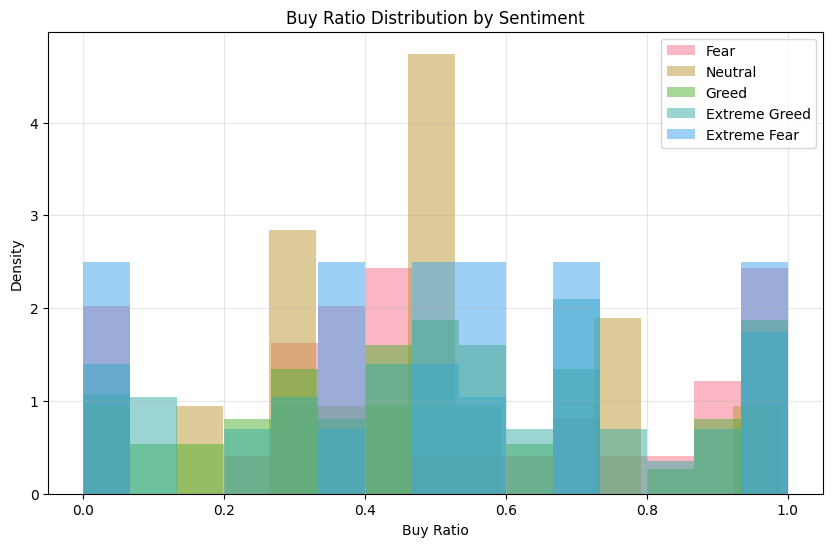

In [ ]:
def plot_buy_ratio_distribution(merged_data):
    plt.figure(figsize=(10, 6))
    for sentiment in merged_data['sentiment_category'].unique():
        if pd.notna(sentiment):
            data = merged_data[merged_data['sentiment_category'] == sentiment]['buy_ratio'].dropna()
            if len(data) > 0:
                plt.hist(data, alpha=0.5, label=sentiment, bins=15, density=True)
    plt.xlabel('Buy Ratio')
    plt.ylabel('Density')
    plt.title('Buy Ratio Distribution by Sentiment')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_buy_ratio_distribution(merged_data)

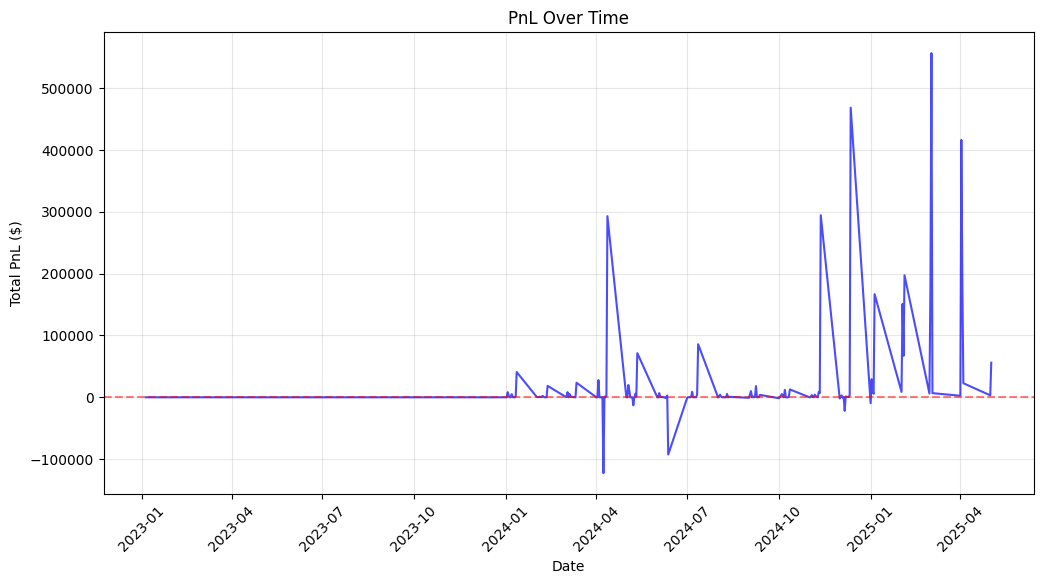

In [ ]:
def plot_pnl_over_time(merged_data):
    df_sorted = merged_data.sort_values('date')
    plt.figure(figsize=(12, 6))
    plt.plot(df_sorted['date'], df_sorted['total_pnl'], 'b-', linewidth=1.5, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Date')
    plt.ylabel('Total PnL ($)')
    plt.title('PnL Over Time')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.show()

plot_pnl_over_time(merged_data)

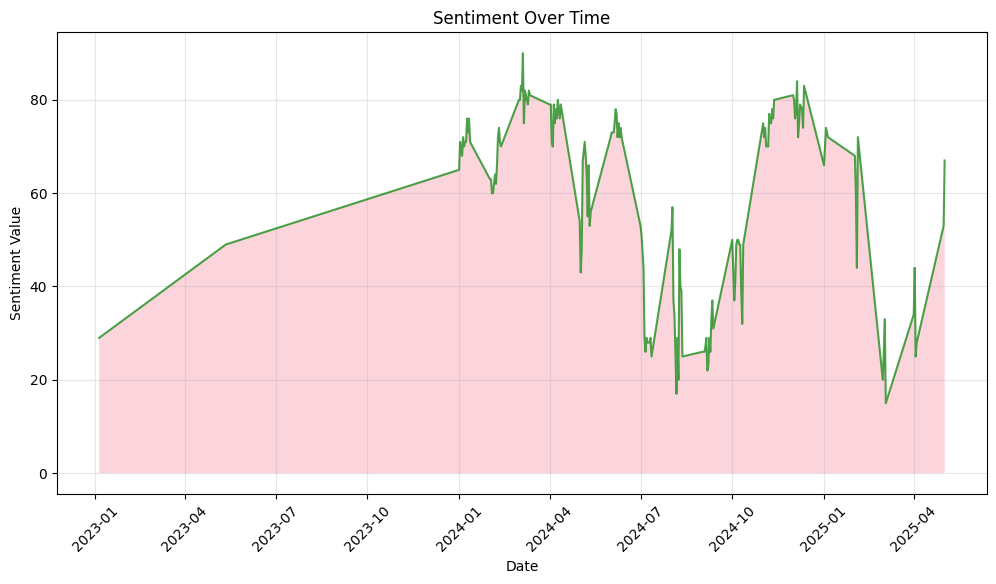

In [ ]:
def plot_sentiment_over_time(merged_data):
    df_sorted = merged_data.sort_values('date')
    plt.figure(figsize=(12, 6))
    plt.plot(df_sorted['date'], df_sorted['sentiment_value'], 'g-', linewidth=1.5, alpha=0.7)
    plt.fill_between(df_sorted['date'], df_sorted['sentiment_value'], alpha=0.3)
    plt.xlabel('Date')
    plt.ylabel('Sentiment Value')
    plt.title('Sentiment Over Time')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.show()

plot_sentiment_over_time(merged_data)

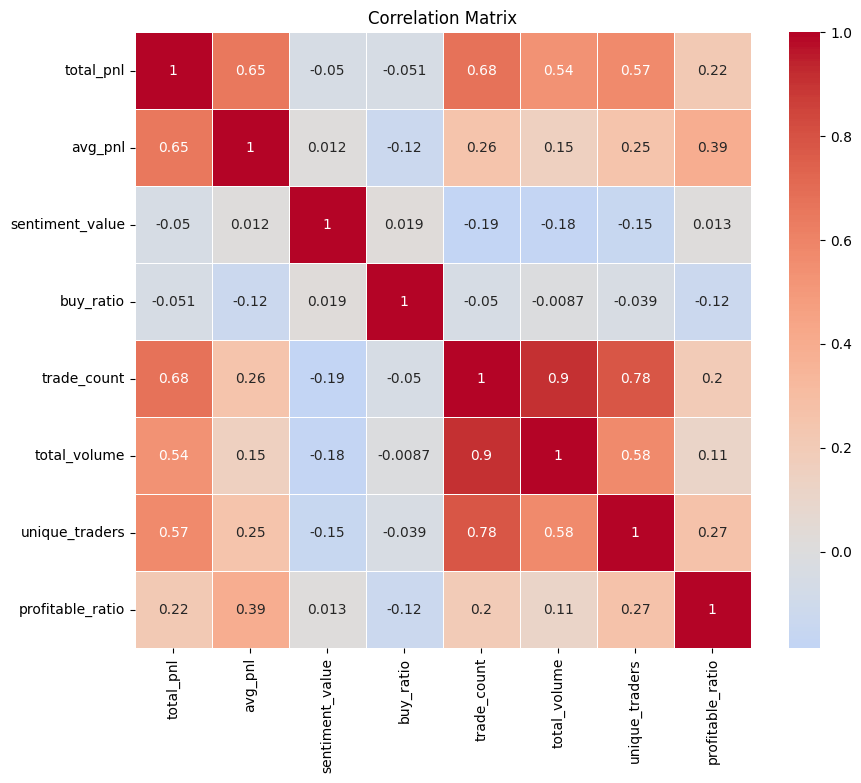

In [ ]:
def plot_correlation_heatmap(merged_data):
    corr_cols = ['total_pnl', 'avg_pnl', 'sentiment_value', 'buy_ratio', 'trade_count',
                 'total_volume', 'unique_traders', 'profitable_ratio']
    available_cols = [col for col in corr_cols if col in merged_data.columns]
    if len(available_cols) > 1:
        corr_matrix = merged_data[available_cols].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5)
        plt.title('Correlation Matrix')
        plt.show()

plot_correlation_heatmap(merged_data)

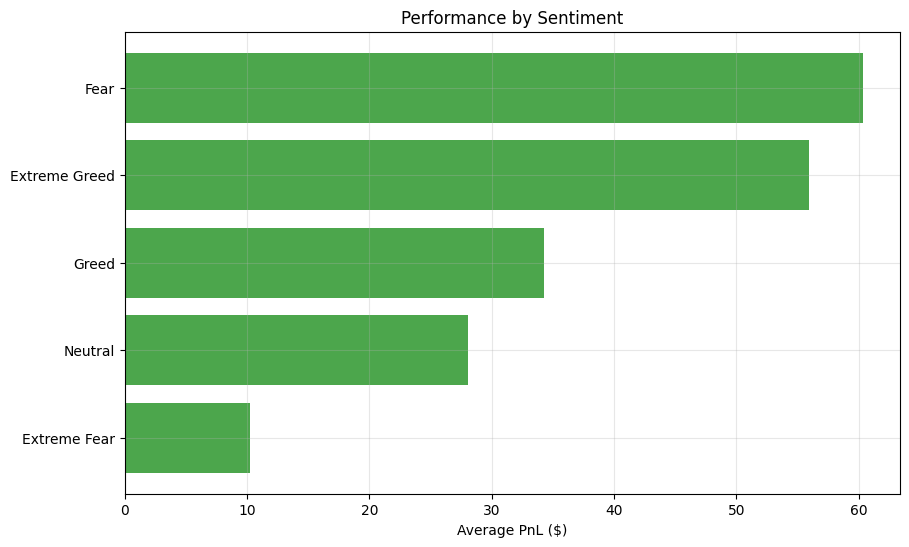

In [ ]:
def plot_performance_by_sentiment(merged_data):
    sentiment_perf = merged_data.groupby('sentiment_category')['avg_pnl'].mean().sort_values()
    colors = ['red' if x < 0 else 'green' for x in sentiment_perf.values]
    plt.figure(figsize=(10, 6))
    plt.barh(sentiment_perf.index, sentiment_perf.values, color=colors, alpha=0.7)
    plt.xlabel('Average PnL ($)')
    plt.title('Performance by Sentiment')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_performance_by_sentiment(merged_data)

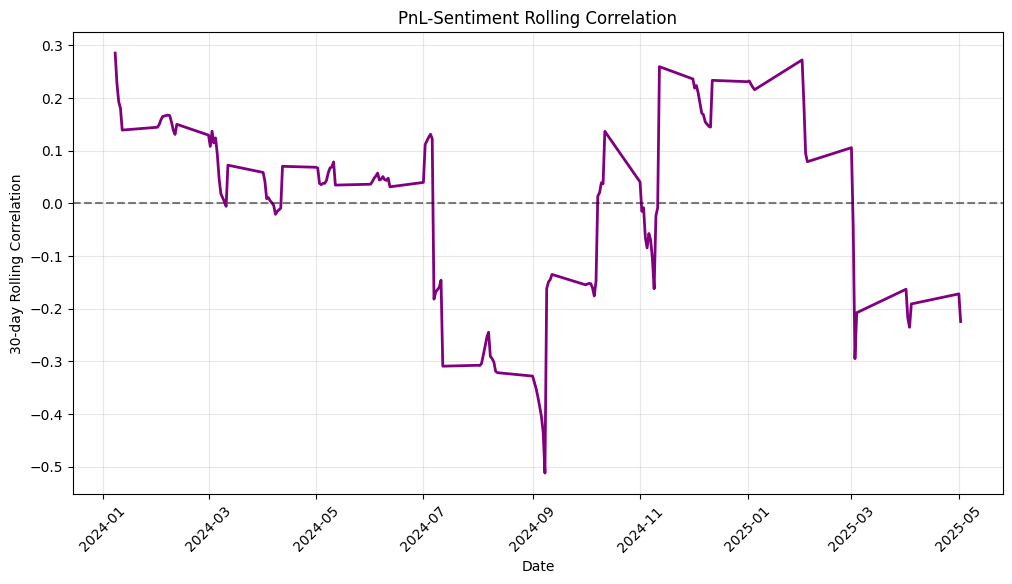

In [ ]:
def plot_rolling_correlation(merged_data):
    df_sorted = merged_data.sort_values('date')
    if len(df_sorted) > 30:
        rolling_corr = df_sorted['total_pnl'].rolling(window=30, min_periods=10).corr(
            df_sorted['sentiment_value'])
        plt.figure(figsize=(12, 6))
        plt.plot(df_sorted['date'], rolling_corr, 'purple', linewidth=2)
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.xlabel('Date')
        plt.ylabel('30-day Rolling Correlation')
        plt.title('PnL-Sentiment Rolling Correlation')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.show()

plot_rolling_correlation(merged_data)

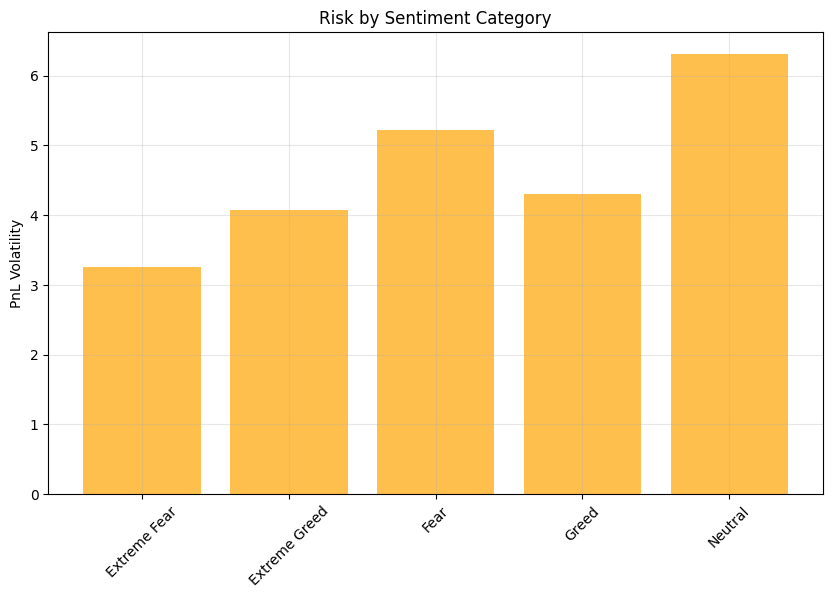

In [ ]:
def plot_volatility_by_sentiment(merged_data):
    if 'pnl_volatility' in merged_data.columns:
        vol_by_sentiment = merged_data.groupby('sentiment_category')['pnl_volatility'].mean()
        plt.figure(figsize=(10, 6))
        plt.bar(vol_by_sentiment.index, vol_by_sentiment.values, alpha=0.7, color='orange')
        plt.ylabel('PnL Volatility')
        plt.title('Risk by Sentiment Category')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.show()

plot_volatility_by_sentiment(merged_data)

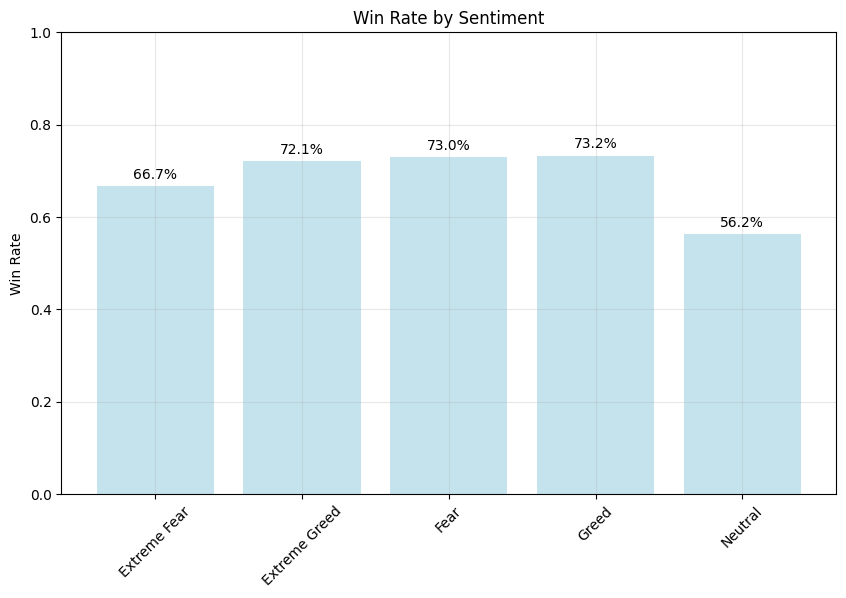

In [ ]:
def plot_win_rate_by_sentiment(merged_data):
    win_rate_by_sentiment = merged_data.groupby('sentiment_category')['profitable_ratio'].mean()
    plt.figure(figsize=(10, 6))
    bars = plt.bar(win_rate_by_sentiment.index, win_rate_by_sentiment.values,
                   alpha=0.7, color='lightblue')
    plt.ylabel('Win Rate')
    plt.title('Win Rate by Sentiment')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.1%}', ha='center', va='bottom')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_win_rate_by_sentiment(merged_data)

In [56]:
def export_results(merged_data, filename='sentiment_trader_analysis_results.csv'):
    print(f"Exporting results to {filename}...")

    merged_data.to_csv(filename, index=False)

    print(f"Results exported to {filename}")

# Execute export
summary = export_results(merged_data)

Exporting results to sentiment_trader_analysis_results.csv...
Results exported to sentiment_trader_analysis_results.csv
